# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### imports

In [1]:
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
import random
import numpy as np
import cv2
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from functools import partial

### magics

In [2]:
%matplotlib inline

### reproducibility and provenance

In [3]:
np.random.seed(1337)

---
## Step 0: Load The Data

In [4]:
training_file = '/home/dieslow/WORKSPACE/PROJECTS/CARZ/DATA/P2/train.p'
testing_file = '/home/dieslow/WORKSPACE/PROJECTS/CARZ/DATA/P2/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_pre, y_train_pre = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
n_train = len(X_train_pre)
n_test = len(X_test)

image_shape = X_train_pre[0].shape

n_classes = len( set(train['labels']).union(set(test['labels'])) )

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

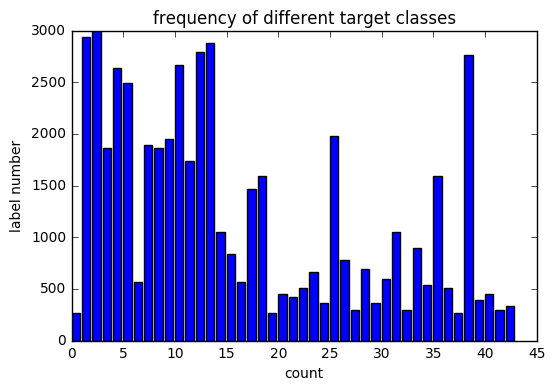

In [6]:
labels = np.concatenate((y_train_pre, y_test))
labels, counts = zip(*Counter(labels).most_common())
plt.bar(labels, counts)
plt.xlabel('count')
plt.ylabel('label number')
plt.title('frequency of different target classes')

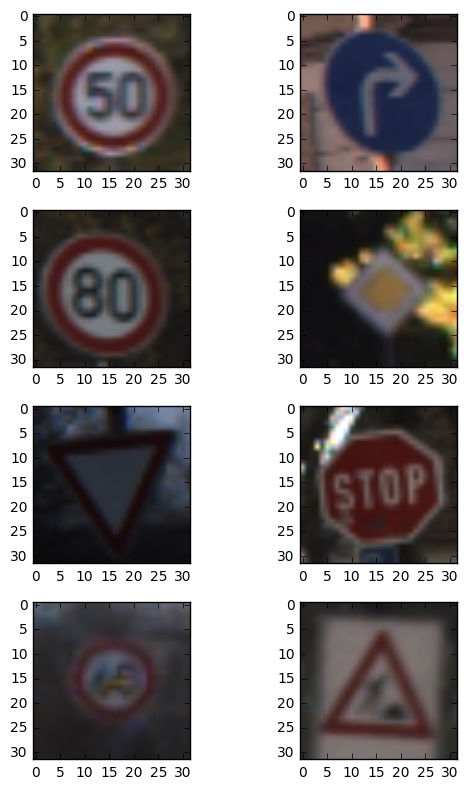

In [7]:
def rand_multiplot_images(plot_shape, images):
    random_images = np.random.choice(np.arange(0, len(images)), plot_shape[0]*plot_shape[1])
    fig, subplts = plt.subplots(nrows=plot_shape[0], ncols=plot_shape[1], figsize=(6,8))
    for i, pair in enumerate(subplts):
        for j, axis in enumerate(pair):
            image_index = random_images[i+(i+j)]
            axis.imshow(images[image_index], cmap='gray')
    plt.tight_layout()

rand_multiplot_images((4,2), X_train_pre)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
def augment_affine_translation(image, x_trans_perc, y_trans_perc):
    y_trans_px = y_trans_perc * image.shape[0]
    x_trans_px = x_trans_perc * image.shape[1]
    
    y_trans = np.random.uniform(-y_trans_px, y_trans_px)
    x_trans = np.random.uniform(-x_trans_px, x_trans_px)
    
    affine_M = np.float32([[1,0,x_trans],[0,1,y_trans]])
    
    augmented_image = cv2.warpAffine(image, affine_M, (image.shape[1], image.shape[0]))
    return augmented_image

def augment_overall_brightness(image):
    brightness_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    
    if np.random.uniform() <= 0.5:
        brightness_image[:,:,2] = brightness_image[:,:,2] * np.random.uniform()
    else:
        brightness_image[:,:,2] = brightness_image[:,:,2] + ((1-brightness_image[:,:,2]) * np.random.uniform())

    augmented_image = cv2.cvtColor(brightness_image,cv2.COLOR_HSV2RGB)
    return augmented_image

def augment_insert_linear_shadow(image):
    # double mgrid method for creating mask adapted very closely from Vivek's blog
    shadow_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    
    y0, y1 = np.floor(image.shape[1]*np.random.uniform(size = 2))
    shadow_mask = np.ones(shadow_image[:,:,1].shape, dtype=np.float64)
    X_m, Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]]
    shadow_mask[((X_m * (y1 - y0)) - (shadow_image.shape[0] * (Y_m - y0)) >= 0)] = np.random.uniform(.1, .8)
    if np.random.uniform() < 0.5: shadow_mask = np.fliplr(shadow_mask)
    shadow_image[:,:,2] = shadow_image[:,:,2] * shadow_mask
    
    augmented_image = cv2.cvtColor(shadow_image, cv2.COLOR_HSV2RGB)
    return augmented_image

def generate_augmented_image(image, augmentation_list):
    aug_count = np.random.randint(1,len(augmentation_list))
    for aug_fx, aug_weight in np.random.choice(augmentation_list, aug_count, replace=False):
        image = aug_fx(image)
    return image

def uniform_by_augmentation(X_data, y_data, aug_fx):
    train_df = pd.DataFrame(list(zip(y_data, X_data)), columns=['label', 'data'])
    perc_df = train_df.groupby('label').size() / train_df.groupby('label').size().max()
    percs = perc_df.to_dict()
    label_counter = Counter(y_data)
    
    county = label_counter.most_common()
    label_names = [x[0] for x in county[1:]]
    label_counts = dict(county)
    count_max = label_counter.most_common(1)[0][1]
    label_max = label_counter.most_common(1)[0][0]
    
    X_additions, y_additions = [X_data], [y_data]
    for label in label_names:
        count = label_counts[label]
        augmentation_blanks = train_df[train_df.label == label].sample(n=np.floor((count_max-count)), replace=True)
        # pandas creates ndarray of ndarrays, fucks up shape
        augmented_data = np.stack(augmentation_blanks['data'].values, axis=0)
        X_additions.append(augmented_data)
        y_additions.append(augmentation_blanks['label'].values)
        
    X_data = np.concatenate(X_additions, axis=0)
    y_data = np.concatenate(y_additions, axis=0)

    assert len(X_data) == len(y_data)
    assert len(X_data) == (len(label_names) + 1) * count_max

    return X_data, y_data

partial_affine = partial(augment_affine_translation, x_trans_perc=.20, y_trans_perc=.20)

aug_fxs = [partial_affine, augment_insert_linear_shadow, augment_overall_brightness]
aug_weights = [0.6, 0.6, 0.6]
aug_list = zip(aug_fxs, aug_weights)

partial_aug = partial(generate_augmented_image, augmentation_list=aug_list)
X_train_aug, y_train_aug = uniform_by_augmentation(X_train_pre, y_train_pre, partial_aug)

X_train_aug = X_train_aug.astype(np.float32, copy=False)
X_train_aug /= 255.
X_train_aug -= 0.5

X_test = X_test.astype(np.float32, copy=False)
X_test /= 255.
X_test -= 0.5

# Shuffle and split data
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
validation_cutoff = int(np.floor(.80*len(X_train_aug)))
X_validation, y_validation = X_train_aug[validation_cutoff:], y_train_aug[validation_cutoff:]
X_train, y_train = X_train_aug[:validation_cutoff], y_train_aug[:validation_cutoff]

print(X_train.shape, y_train.size)

print(X_validation.shape)
print(X_train.shape)
print(X_test.shape)

print(y_validation.shape)
print(y_train.shape)
print(y_test.shape)

/home/dieslow/WORKSPACE/venv/lib/python3.5/site-packages/pandas/core/generic.py:2644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


(77400, 32, 32, 3) 77400
(19350, 32, 32, 3)
(77400, 32, 32, 3)
(12630, 32, 32, 3)
(19350,)
(77400,)
(12630,)


### Model Architecture

In [10]:
def inception_layer():
    # to come
    pass
    
def conv_layer(x, filter_size=3, filter_count=96, pooling=True, double_layer=True):
    mu = 0
    sigma = 0.1
        
    input_depth = int(x.get_shape()[3])
    
    conv0_W = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, input_depth, filter_count), mean = mu, stddev = sigma))
    conv0_b = tf.Variable(tf.zeros(filter_count))
    conv0   = tf.nn.conv2d(x, conv0_W, strides=[1, 1, 1, 1], padding='SAME') + conv0_b
    conv = tf.nn.relu(conv0)

    #change this to for loop for count of inner iteration
    if double_layer:
        conv1_W = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, filter_count, filter_count), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(filter_count))
        conv1   = tf.nn.conv2d(conv, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
        conv = tf.nn.relu(conv1)

    if pooling:
        conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    return conv
                           
                        
def MyNet(x):    
    mu = 0
    sigma = 0.1
    
    class_size = 43

    #LET NETWORK LEARN COLOR MAP
    with tf.variable_scope("conv_color"):
        convl_out_color = conv_layer(x, 1, 3, pooling=False, double_layer=False)
    
    #TODO: for filter size and count in filters = [[3,96], [5, 128], ...] :
    with tf.variable_scope("conv0"):
        convl_out_0 = conv_layer(x, 5, 32)
        fc0 = flatten(convl_out_0)

    with tf.variable_scope("conv1"):
        convl_out_1 = conv_layer(convl_out_0, 3, 64)
        fc1 = flatten(convl_out_1)

    with tf.variable_scope("conv2"):
        convl_out_2 = conv_layer(convl_out_1, 3, 96)
        fc2 = flatten(convl_out_2)
    
    flat = tf.concat(1, [fc0, fc1, fc2])
    flattened_size = int(flat.get_shape()[1])
    
    # Layer 3: Fully Connected. Input = 24576. Output = 43.
    with tf.variable_scope("fc0"):
        fc1_W = tf.Variable(tf.truncated_normal(shape=(flattened_size, 200), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(200))
        fc1 = tf.matmul(flat, fc1_W) + fc1_b
        fc1 = tf.nn.relu(fc1)
        fc1_drop = tf.nn.dropout(fc1, keep_prob)


    # Layer 4: Fully Connected. Input = 120. Output = 84.
    with tf.variable_scope("fc1"):
        fc2_W = tf.Variable(tf.truncated_normal(shape=(200, 100), mean = mu, stddev = sigma))
        fc2_b = tf.Variable(tf.zeros(100))
        fc2 = tf.matmul(fc1_drop, fc2_W) + fc2_b
        fc2 = tf.nn.relu(fc2)
        fc2_drop = tf.nn.dropout(fc1, keep_prob)


    # Layer 5: Fully Connected. Input = 84. Output = 10.
    with tf.variable_scope("fc2"):
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

(?, 13824)
13824


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [ ]:
# placeholders for a batch of input images
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

rate = 0.001
# rate = 0.0001 WILL REQUIRE MORE TRAINING TIME

with tf.variable_scope('loss'):
    logits = MyNet(x)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)
    
with tf.variable_scope('training'):
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

with tf.variable_scope('evaluation'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
EPOCHS = 25
BATCH_SIZE = 4*128

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...
EPOCH 1 ...
Validation Accuracy = 0.790

EPOCH 2 ...
Validation Accuracy = 0.964

EPOCH 3 ...
Validation Accuracy = 0.984

EPOCH 4 ...
Validation Accuracy = 0.992

EPOCH 5 ...
Validation Accuracy = 0.996

EPOCH 6 ...
Validation Accuracy = 0.996

EPOCH 7 ...
Validation Accuracy = 0.997

EPOCH 8 ...
Validation Accuracy = 0.998

EPOCH 9 ...
Validation Accuracy = 0.997

EPOCH 10 ...
Validation Accuracy = 0.998

EPOCH 11 ...
Validation Accuracy = 0.999

EPOCH 12 ...
Validation Accuracy = 0.999

EPOCH 13 ...
Validation Accuracy = 0.999

EPOCH 14 ...
Validation Accuracy = 0.998

EPOCH 15 ...
Validation Accuracy = 0.999

EPOCH 16 ...
Validation Accuracy = 0.999

EPOCH 17 ...
Validation Accuracy = 0.999

EPOCH 18 ...
Validation Accuracy = 0.999

EPOCH 19 ...
Validation Accuracy = 0.999

EPOCH 20 ...
Validation Accuracy = 0.999

EPOCH 21 ...
Validation Accuracy = 0.999

EPOCH 22 ...
Validation Accuracy = 0.999

EPOCH 23 ...
Validation Accuracy = 0.999

EPOCH 24 ...
Validation Accurac

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.973


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [146]:
images = []
for filename in os.listdir('./extra_sign_photos/'):
    image = cv2.imread('./extra_sign_photos/' + filename, 1)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    res = cv2.resize(image, (32,32), interpolation=cv2.INTER_AREA)
    images.append(res)
    
print(len(images))

### Predict the Sign Type for Each Image

In [3]:
def predict(X_predict):
    sess = tf.get_default_session()
    init_op = tf.initialize_all_variables()
    prediction = tf.nn.softmax(logits)
    top_k_operation = tf.nn.top_k(prediction, k=5, sorted=True, name=None)
    top_k_output = sess.run(top_k_operation, feed_dict={x: X_predict, keep_prob:1.0})
    return top_k_output

X_predict = np.stack(images, axis=0)
print(X_predict.shape)
X_predict /= 255.
X_predict -= 0.5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predict_results = predict(X_predict)

### Analyze Performance

Given the number of images I collected, I chose to take a slightly more nuanced approach to hand scoring the results, the scores given by the classifier are given below in the plots of the top k softmax scores.

I found:

* 24 signs that were in the provided data set which were marked incorrectly
* 10 signs that were in the provided data set which were marked correctly

This yields:

In [161]:
print('{}% accuracy for those signs that matched our training set'.format(100 * 10 / 34.))

29.41176470588235% accuracy for those signs that matched our training set


I also found:

* 7 signs that were not represented in our training data, but which were classified into a very related category
* 14 signs that had nothing even remotely close in our training set
* 4 signs (not distinct from the above errors) that were incorrect on internal numbers alone

Also notable was the supreme confidence of the classifier in the scores, only a handful of the below charts show that there was even a unique second place, and it is almost always a miniscule score. In all other cases, you see the algorithm simple goes through sequentially picking 0-scores. Also of note was that the classifier seems to default to yield classifications unusually often.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

/home/dieslow/WORKSPACE/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


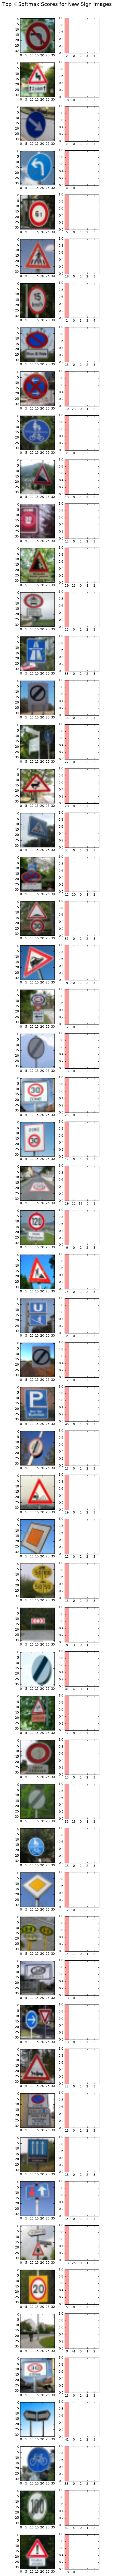

In [159]:
opacity = 0.4
bar_width = 0.6

plot_shape = (len(images),2)
images = images

image_indices = np.arange(0, len(images))
fig, ax = plt.subplots(nrows=plot_shape[0], ncols=plot_shape[1], figsize=(4, plot_shape[0] * 2))
fig.suptitle('Top K Softmax Scores for New Sign Images', fontsize=16)

for i, axis_pair in enumerate(ax):
    axis_pair[0].imshow(images[i], cmap='gray')
    index = np.arange(len(predict_results.indices[i]))
    axis_pair[1].bar(index, 
                  predict_results.values[i], 
                  bar_width,
                  alpha=opacity,
                  color='r')
    labels = [str(x) for x in predict_results.indices[i]]
    axis_pair[1].set_xticks(index + (bar_width / 2))
    axis_pair[1].set_xticklabels(labels)
    plt.legend()
    plt.tight_layout()

fig.subplots_adjust(top=0.974)

plt.show()

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 